# Evolving Niches with Noise
## Preliminary results for noise on channels 0-2 after 300 generations

This simulation uses one of the runs from the noise-free simulations and evolves it further under noisy conditions.
These populations didn't experience noise until generation 300, at which point constant noise was added to channels 0-2.
The next 300 generations (300-599) were evolved under these noisy conditions.
The final 300 generations were simulated 50 times from the same base run to assess the range of possible responses to noise.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%aimport -matplotlib
%aimport -pandas
%aimport -seaborn
%aimport -logging
%aimport -os

import analysis.ks
import dataframe.calculations.spectrum
from dataframe.calculations import specific_generation_over_runs
import visualize.dataframe
plt.style.use(['dark_background'])

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(threadName)s - %(name)s - %(levelname)s - %(message)s')

rootlogger = logging.getLogger()
f = logging.Filter(name='evolvingniches')
logger = logging.getLogger('evolvingniches.run')
rootlogger.addFilter(f)
logger = logging.getLogger('evolvingniches.jupyter')

In [2]:
directory = '/Users/davk/Documents/phd/projects/EvolvingNiches/data/20D22_g300_c012_i1_600x50/'
base_run = 104

spectra = pd.read_parquet(directory + 'encoded_spectrum.parquet')
species = pd.read_parquet(os.path.join(directory, 'species.parquet'))
subspecies = pd.read_parquet(os.path.join(directory, 'subspecies.parquet'))
individuals = pd.read_parquet(os.path.join(directory, 'individuals.parquet'))

last_10_species = specific_generation_over_runs(range(589, 599), data=species)
run_role_fitness = last_10_species.groupby(['run','role'])['fitness'].mean()
run_fitness = run_role_fitness.groupby('run').mean()

spectra_ob_fitness = spectra.join(run_fitness).sort_values(['fitness','generation'], ascending=[False, True])
spectra_ob_fitness = spectra_ob_fitness.drop(columns='fitness')

## Average of the 50 runs

The plot below shows the spectrum of the base simulation (generations 0-299) and the average spectrum of all 50 noisy continuations (generations 300-599).
The average response was to rapidly abandon the noisy channel 2 in favour of the open channel 6.
However, most populations seemed unable to leave channel 0 in the same way.
Perhaps this is because the signal on channel 0 was actually steadier in the final generations of the noise-free simulation than on channel 2.

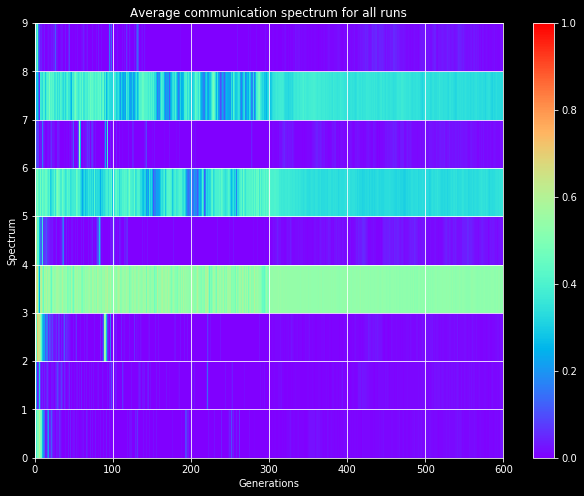

In [13]:
visualize.dataframe.plot_spectrum(spectra, vmin=0.0, vmax=1.0, view=True, filename='spectrum_noise_onset_b4.svg')

## Individual Runs

It's important to see the variation in the individual runs as well.
The 50 runs are split between the two plots below showing 25 runs each.
The runs are labelled and ordered from left-to-right, top-to-bottom by the fitness of the final 10 generations, with the first plot being the most fit and the last one being the least.



In [4]:
# visualize.dataframe.plot_run_spectra(spectra, vmin=0.0, vmax=1.0, view=True, filename=None, shape=(5, 5), base_run=base_run)
#
# visualize.dataframe.plot_run_spectra(spectra.loc[25:], vmin=0.0, vmax=1.0, view=True, filename=None, shape=(5, 5), base_run=base_run)


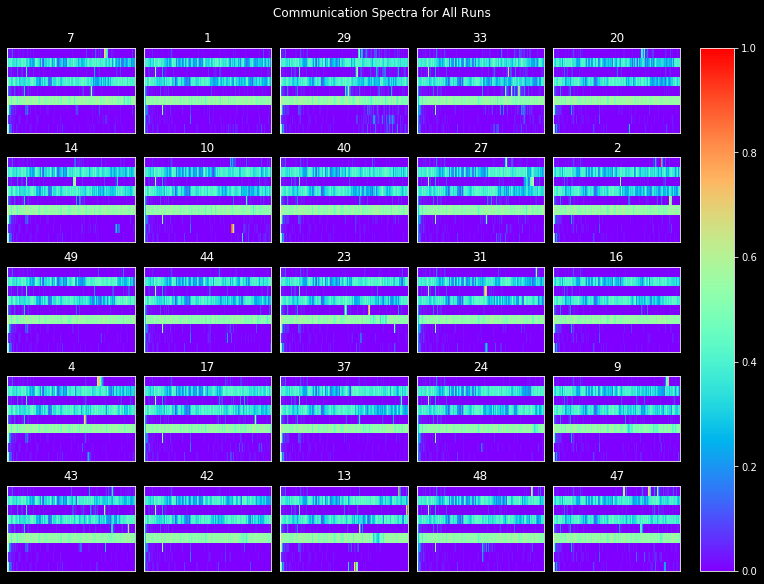

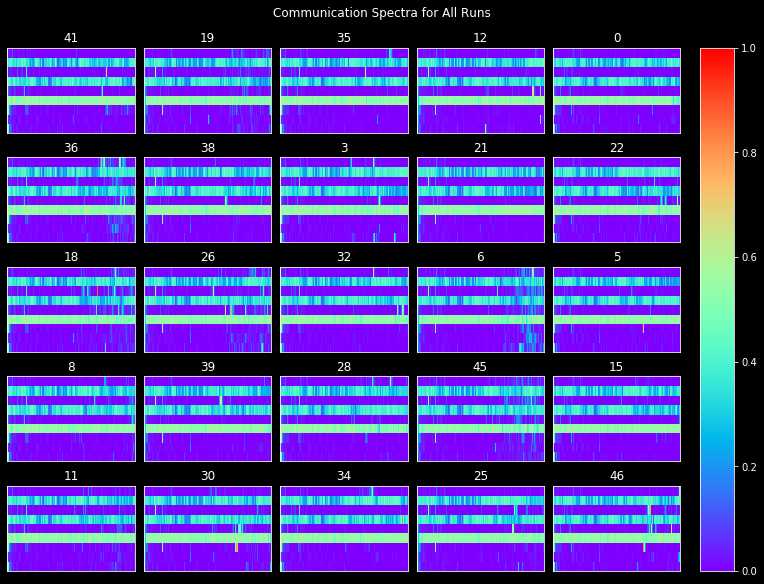

In [5]:
visualize.dataframe.plot_run_spectra(spectra_ob_fitness, vmin=0.0, vmax=1.0, view=True, filename=None, shape=(5, 5), base_run=base_run, numbering=True)

last_25 = spectra_ob_fitness.loc[spectra_ob_fitness.index.get_level_values('run').unique()[25:]]
visualize.dataframe.plot_run_spectra(last_25, vmin=0.0, vmax=1.0, view=True, filename=None, shape=(5, 5), base_run=base_run, numbering=True)

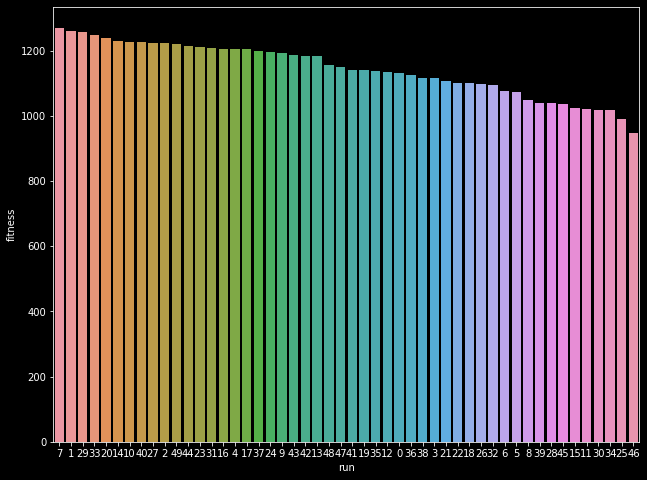

In [6]:
order = run_fitness.reset_index().sort_values('fitness', ascending=False)['run']
sns.barplot(x='run', y='fitness', order=order, data=run_fitness.reset_index())
plt.show()

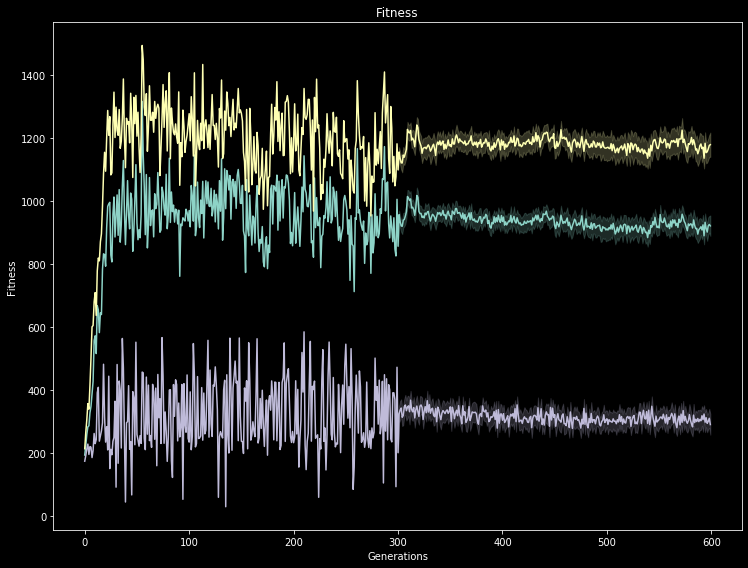

In [7]:
#TODO Show the averages and also an example
visualize.dataframe.plot_species_fitness(species, species=0, role='sender', view=True, filename=None)

## Runs 10, 45, 17

I've highlighted runs 25, 45, and 17 below because they are each interesting in their own way.
### Run 10
Run 10 is a pretty average run.
The population almost immediately drops channel 2 in favour of channel 6, but keeps channel 0 for the duration of the simulation.
It pretty quickly regains much of its fitness and seems to be content (not to personify too much) with staying there, just below its previous fitness level.
This seems to indicate that, in fact, all of the chatter on channel 0 wasn't adding much to the overall fitness of the species.

*NB* If we talk about this, we should see what happens if we knock out channel 0
*NB* If we look at the network, we should see whether they already look at different channels before we switch...
*NB* If you disable speciation, they might not be able to switch so rapidly...HYPOTHESIS in discussion


### Run 45
Run 45 is the only one that seemingly gets it "right".
It drops channels 0 and 2 right away and picks up channel 3 almost immediately.
Eventually, it also picks up channel 5 and has now moved fully away from the noisy channels towards a 3-channel noiseless setup.
Its fitness takes a huge hit by dropping both of those channels and seems to dip down even further before it picks up channel 5.
It is remarkably able to raverse this fitness valley and ends up close to its original fitness by the end of the run.

The senders are quite unspeciated here, but the receivers are very diverse.
**NB** Does species diversity help to adapt quickly?
I can look at the numbers for nodes and network connections and species and fitness before and after noise.

**NB** The reviewer might ask what happens without species. We wanted to have a more fine-grained idea. We wanted to know whether more species means more recovery.
HYP: Speciation allows for resilience. More network complexity for receivers? 

### Run 17
Run 17 appears to adopt the strategy of simply staying with what it has.
It simply keeps using the three channels that it was using before, albeit with a seemingly higher intensity on 0 and 2 (is this right?)
Its fitness is lower than before the onset of noise, but remains relatively steady throughout after an initial drop.


Plotting run 10
Plotting run 45
Plotting run 17


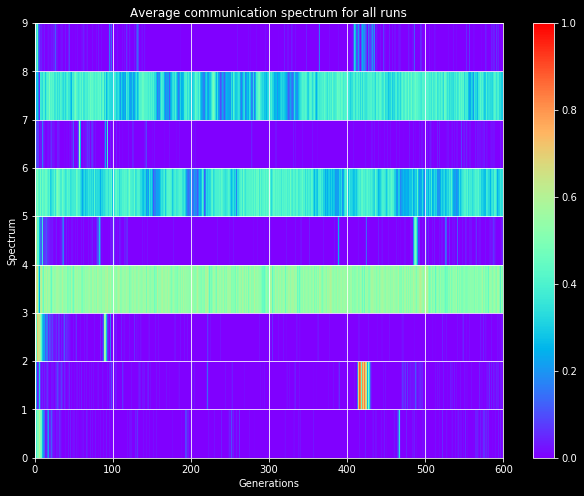

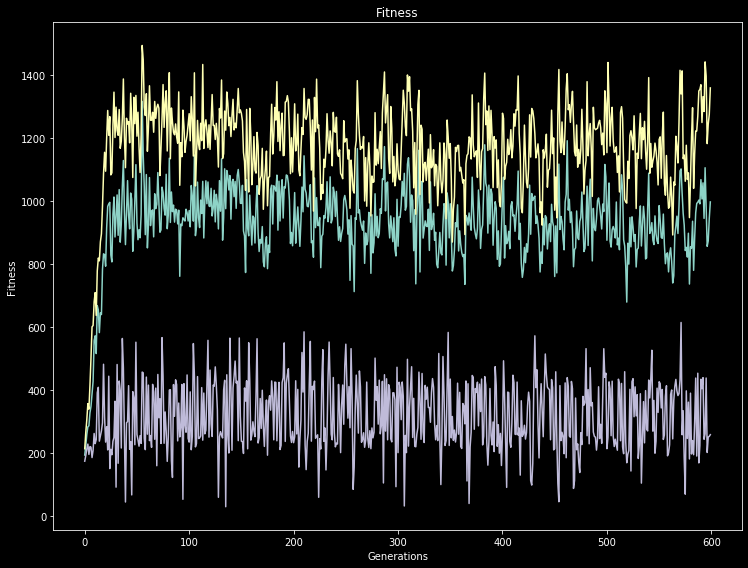

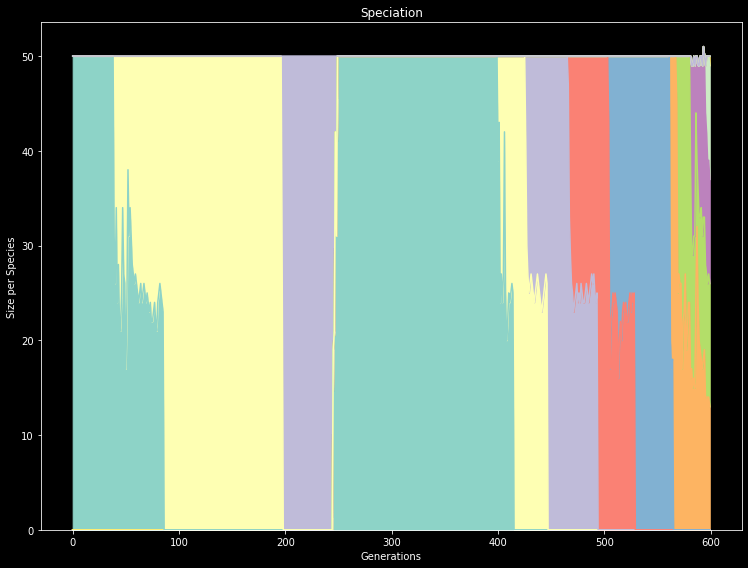

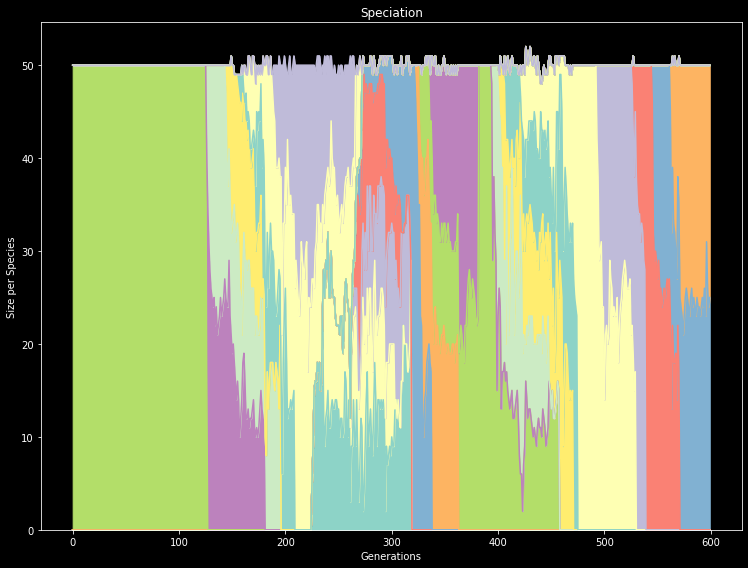

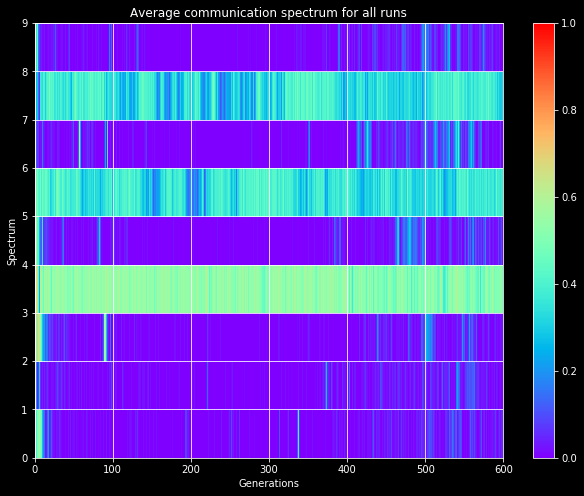

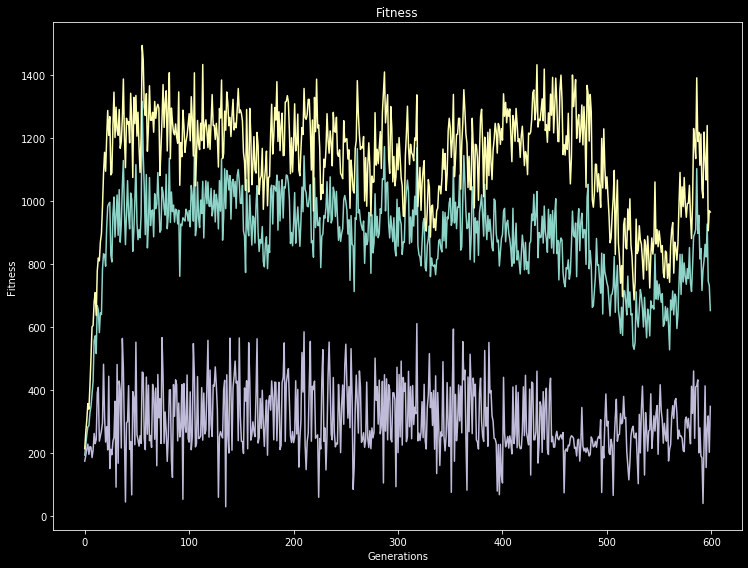

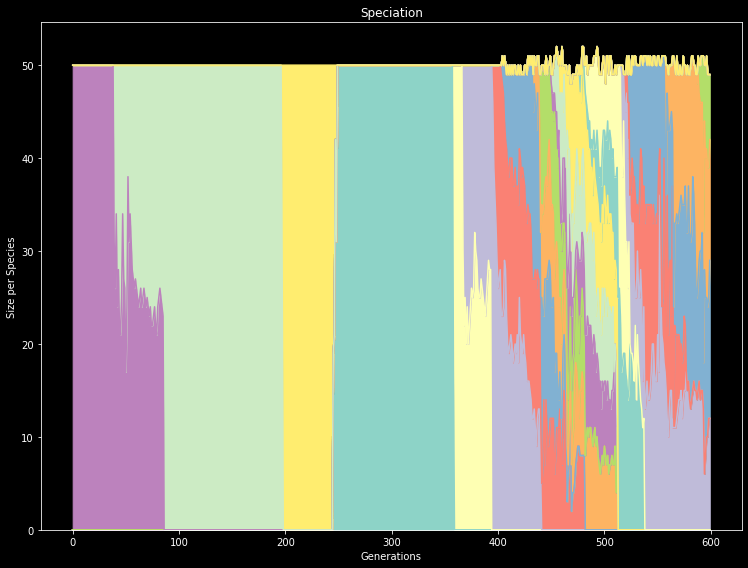

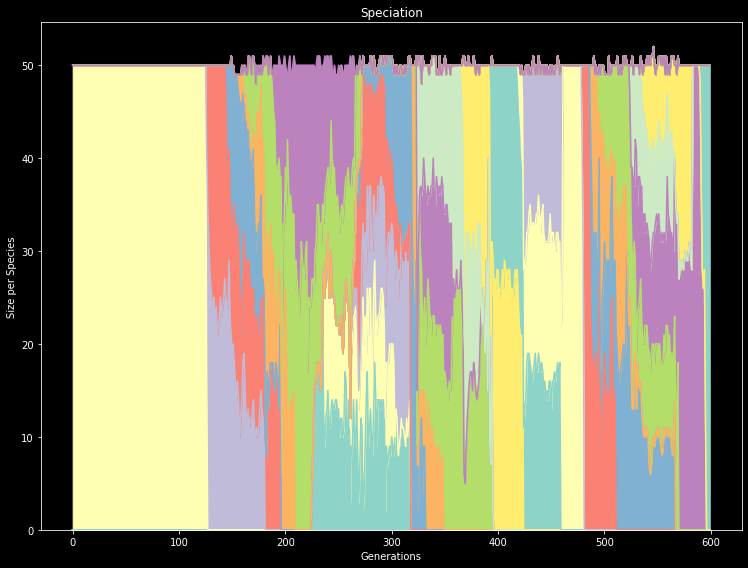

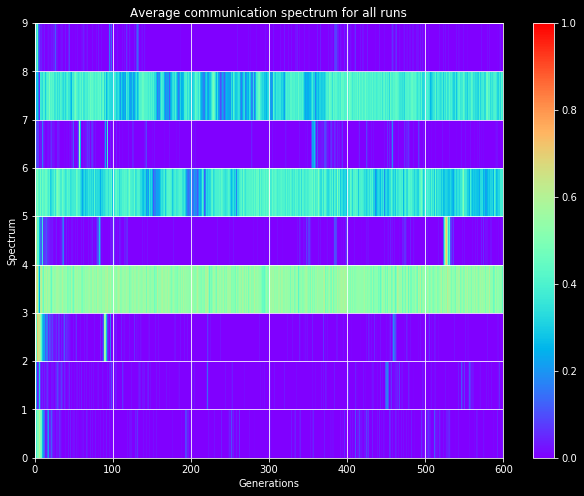

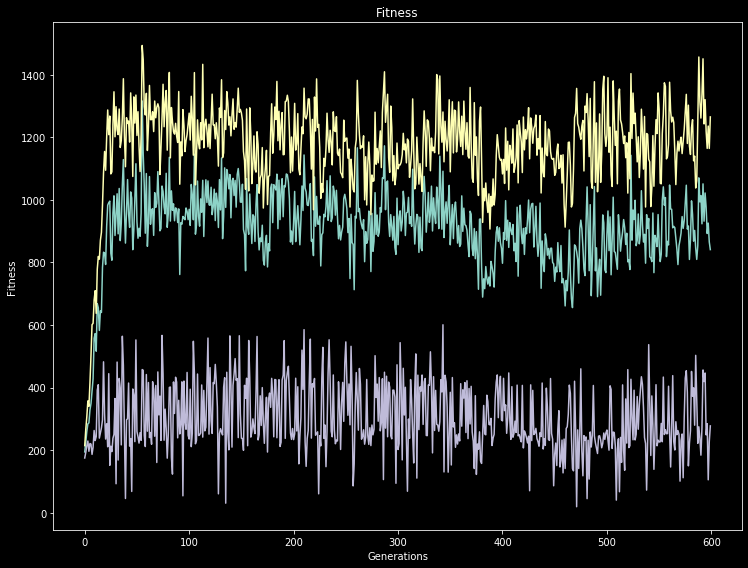

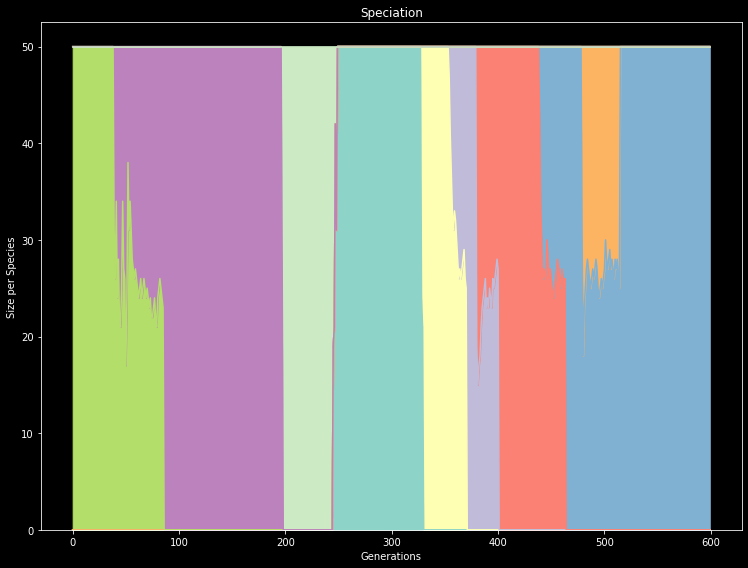

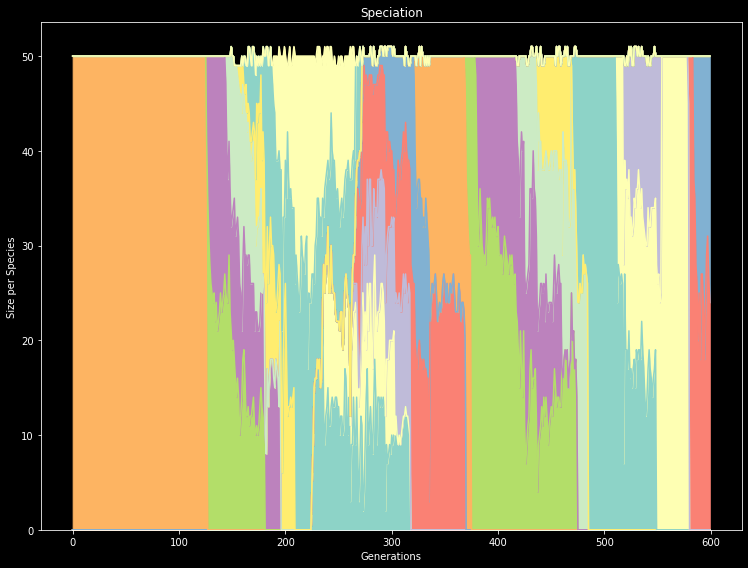

In [8]:
run_list = [10, 45, 17]

for n in run_list:
    print('Plotting run {}'.format(n))
    run = spectra.loc[((n, base_run), slice(None), slice(None)),:]
    visualize.dataframe.plot_spectrum(run, vmin=0.0, vmax=1.0, view=True, filename=None)
    fit = species.loc[((n, base_run), slice(None), slice(None)),('fitness','max','min')]
    visualize.dataframe.plot_species_fitness(fit, species=0, role='sender', view=True, filename=None)
    sub = subspecies.loc[((n, base_run), slice(None), slice(None)),:]
    visualize.dataframe.plot_subspecies_abundances(sub, species=0, role='sender', view=True, filename=None)
    visualize.dataframe.plot_subspecies_abundances(sub, species=0, role='receiver', view=True, filename=None)

# Questions and To Do
## To Do
* Plot the fitnesses because that will help answer some of this.
* Run a simulation where only one channel begins in the noisy zone (this was using two channels that became noisy). Are more of the runs able to abandon the channel in this scenario?

## Questions
1. Why did most of the simulations move away from channel 2 but not 0? Both were equally noisy. Was channel 2 adding less to the fitness?
1. Why did most of them pick up channel 6? There seems to have been some recent activity on that channel? Was there a subpopulation that was maintaining connections there?
1. Is run 45 actually the fittest? Did it manage to find a path around a local optimum that most others didn't?
1. Is the conclusion that the population was generally able partially adapt, but not fully, and that the noise still tended to impact its fitness? 

## Also
In addition to this, I have done a bunch of other runs that will be part of the paper:
1. 50 runs of 300 generations with no noise (run number 5, the base run for these simulations comes from this set)
1. 50 runs of 300 generations with noise on channels 0-2 to compare with the noiseless runs.
1. 50 runs of run number 5 + another 300 generations with no noise for comparison with the runs plotted above.
1. A set of 50 noisy and 50 noiseless runs with a different base (run number 4 from **2**). In this base run, all 3 of the used channels are outside the range 0-2, where noise comes in after generation 300, so not much changes. But it is good for showing that it is the presence of noise on channels that are used that is important!

In [9]:
%%script false --no-raise-error

last10 = dataframe.calculations.spectrum.specific_generation_over_runs(range(589,599), spectra=spectra)

visualize.dataframe.plot_channel_volume_histogram(last10, view=True, filename=None)

In [10]:
%%script false --no-raise-error

ks_stat, ks_p = analysis.ks.kolmogorov_smirnov_matrix(last10)

stat_cluster_centers_indices, stat_labels = analysis.ks.kolmogorov_smirnov_clusters(ks_stat)
p_cluster_centers_indices, p_labels = analysis.ks.kolmogorov_smirnov_clusters(ks_p) 

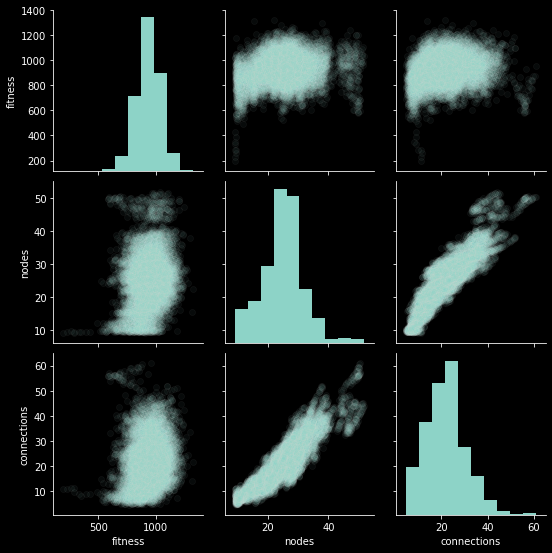

In [12]:
visualize.dataframe.plot_pairplot(species.loc[:, ('fitness','nodes','connections')], role='sender', view=True, filename=None)